## Load modules and data

In [10]:
#Base
from os import path
import numpy as np
import xarray as xr
import pandas as pd
from scipy import interpolate
import scipy.stats as st
from tqdm.notebook import trange, tqdm
from statsmodels.stats.multitest import fdrcorrection
import ray

#Plot
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

color_names=['amber','red','windows blue','faded green',
             'dusty purple',
             'orange',
             'steel blue',
             'pink',
             'greyish',
             'mint',
             'clay',
             'light cyan',
             'forest green',
             'pastel purple',
             'salmon',
             'dark brown',
             'lavender',
             'pale green',
             'dark red',
             'gold',
             'dark teal',
             'rust',
             'fuchsia',
             'pale orange',
             'cobalt blue',
             'mahogany',
             'cloudy blue',
             'dark pastel green',
             'dust',
             'electric lime',
             'fresh green',
             'light eggplant',
             'nasty green']
 
color_palette = sns.xkcd_palette(color_names)
cc = sns.xkcd_palette(color_names)

#V1DD
from allen_v1dd.client import OPhysClient, OPhysSession

#Network 
import networkx as nx
import networkx.algorithms.community as nx_comm
from networkx.algorithms.community import greedy_modularity_communities, naive_greedy_modularity_communities
from networkx.algorithms.efficiency_measures import global_efficiency, local_efficiency

%matplotlib inline
%load_ext autoreload
%autoreload 2

PlotDir = '/home/david.wyrick/projects/V1DD/plots'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
## Load data
base_folder = r"\\allen\programs\mindscope\workgroups\surround\v1dd_in_vivo_new_segmentation\data" #Server
base_folder = "/data/v1dd_in_vivo_new_segmentation" # Local on robinson for golden mouse
client = OPhysClient(base_folder)



In [3]:
##===== Load session from golden mouse =====##
mouse_id = 409828; col = 1; vol = 3; plane = 3

sess = client.load_ophys_session(mouse=mouse_id, column=col, volume=vol)
print(f"Loaded ophys session {sess.get_session_id()} (mouse {sess.get_mouse_id()}, column {sess.get_column_id()}, volume {sess.get_volume_id()})")


Loaded ophys session M409828_13 (mouse 409828, column 1, volume 3)


In [4]:
data_list = []; ts_list = []; roiID_list = []
for plane in range(1,7):
    
    #Get dff traces
    dff_xarr = sess.get_traces(plane, trace_type='dff',valid_only=True)
    # deconv_dff_full, ts_full = sess.get_traces(plane, trace_type='events')

    #Only take valid cells
    mask = sess.is_roi_valid(plane)
    indy = np.where(mask)[0]

    #Subsample
    dff = dff_xarr.sel(roi = indy)
    data_list.append(dff_xarr)
    ts_list.append(dff_xarr.coords['time'].values)
    
    roi_ids = np.array(sess.get_rois(plane))
    roi_ids_valid = roi_ids[indy]
    roiID_list.append(roi_ids_valid)


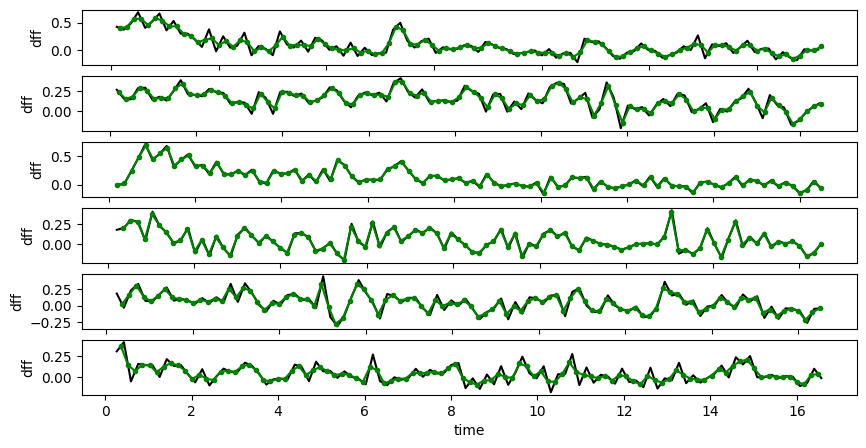

In [5]:
## Interpolate all planes to the same time
ts_array = np.array(ts_list)
ts_mean = np.mean(ts_array,axis=0)
ts_all = np.sort(np.concatenate(ts_list))
data_list_interp = []

fig, axes = plt.subplots(6,1,figsize=(10,5))

plotslice = slice(0,75)
for ii, dff_xarr in enumerate(data_list):
    # print(dff_xarr.coords['roi'])
    ax = axes[ii]
    ts = ts_list[ii]
    data_interp = dff_xarr.interp(time=ts_mean,method='linear',kwargs={'bounds_error':False})
    data_list_interp.append(data_interp)

    # data_list_interp.append(data_interp)
    # ax.plot(ts[plotslice],data[0,plotslice],'.-',color='k',lw=2)
    dff_xarr.sel(roi=0,time=ts[:100]).plot.line(color='k',ax=ax)
    data_interp.sel(roi=0,time=ts_mean[:100]).plot.line(color='g',marker=".",ax=ax)
    ax.set_title('')
    # ax.plot(ts_mean[plotslice],data_interp[0,plotslice],'.-',color='g',lw=2)
    # ax.plot(ts_all[slice(0,75*6)],data_interp[0,slice(0,75*6)],'-',color='g')


In [12]:
## Using new method
data_list_interp = sess.interpolate_all_plane_traces_to_common_time_series(trace_type='events',reload=True)

# Select only spontaneous periods
#Get stimulus times for spontaneous
stim_table, stim_meta = sess.get_stimulus_table("spontaneous")
tStart, tEnd = stim_table.at[0, "start"], stim_table.at[0, "end"]

data_list_spont = []
for data_xarr in data_list_interp:
    data_list_spont.append(data_xarr.sel(time=slice(tStart-32/6,tEnd+32/6)))

ts = data_list_spont[0].coords['time'].values

event_traces = np.concatenate(data_list_spont)
# dF_traces = np.concatenate(data_list_spont)



In [7]:
nNeurons_plane = [len(t) for t in data_list_interp]
nNeurons_plane

[409, 470, 483, 478, 438, 430]

In [12]:
np.save(f'../data_frames/dff_{mouse_id}_{col}{vol}.npy',dF_traces)

In [8]:
spike_prob = np.load(f'../data_frames/predictions_dff_{mouse_id}_{col}{vol}.npy')
spike_prob.shape

(2708, 1885)

In [17]:
nSpkCounts = np.sum(dF_traces,axis=1)
maxFR_neurons = np.argsort(nSpkCounts)[::-1]
maxFR_neurons

array([ 972,  882,  928, ...,  670, 2688, 1331])

In [ ]:
dF_traces, spike_prob, event_traces

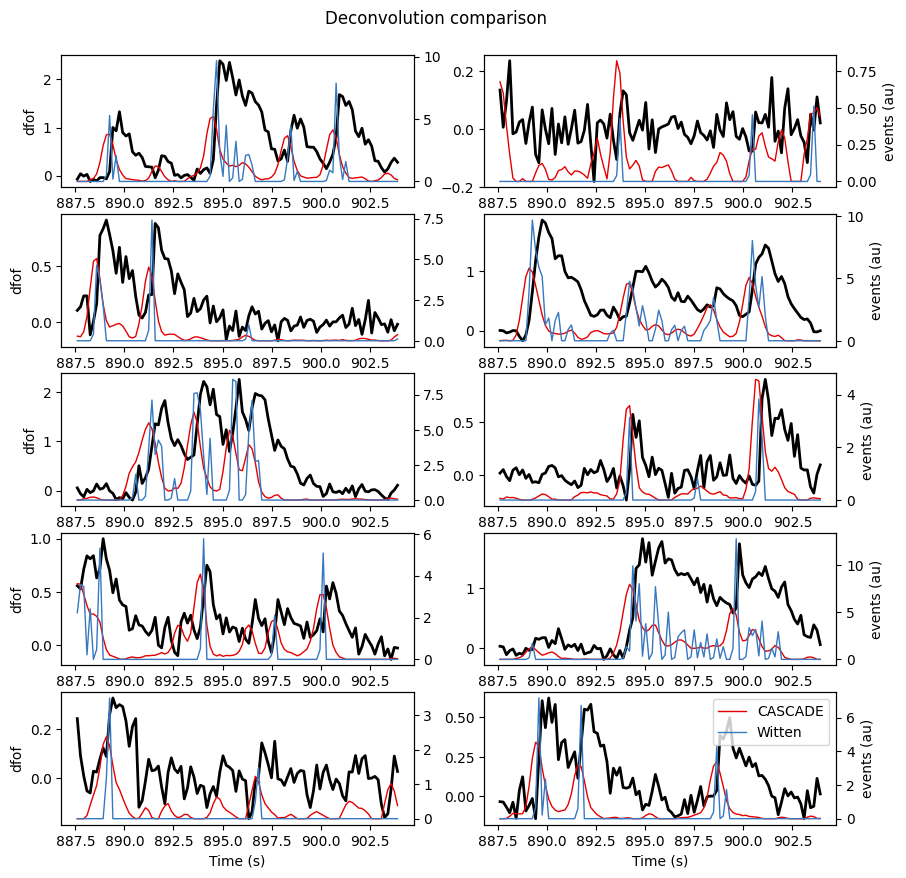

In [18]:
fig, axes = plt.subplots(5,2,figsize=(10,10))
plt.suptitle('Deconvolution comparison',y=0.925)
plotslice = slice(100,200)
for ii, iN in enumerate(maxFR_neurons[:10]):
    ax = axes[ii//2,ii%2]

    ax1 = ax.twinx()

    y = spike_prob[iN]; yz= y/np.nanstd(y)
    ax1.plot(ts[plotslice],yz[plotslice],'-',color=cc[1],label='CASCADE',lw=1)
    y = event_traces[iN]; yz= y/np.nanstd(y)
    ax1.plot(ts[plotslice],yz[plotslice],'-',color=cc[2],label='Witten',lw=1)

    ax.plot(ts[plotslice],dF_traces[iN,plotslice],'-k',lw=2)

    if ii%2 == 0:
        ax.set_ylabel('dfof')
    else:
        ax1.set_ylabel('events (au)')
    
    if ii//2 == 4:
        ax.set_xlabel('Time (s)')
ax1.legend()

# plt.savefig(path.join(PlotDir,f'deconvolution_compare_{mouse_id}_{col}{vol}.pdf'))


## Calculate pairwise correlations between neurons
separated by running and rest

In [13]:

running_speed = sess.get_running_speed()
running_spont = running_speed.sel(time=slice(tStart, tEnd))
# running_mask = calculate_running_mask(running_speed)
running_mask =  running_speed > 3
running_mask_spont = running_spont > 3


In [14]:
ts = data_list_spont[0].coords['time'].values


In [15]:
# def create_running_mask_for_dfftraces(running_mask, ts, tWindow = 0.250, run_thresh=3):
tWindow = 0.250
running_mask_dff = np.zeros(ts.shape)
for ii, t in enumerate(ts):
    tmp = np.array(running_mask.sel(time=slice(t-tWindow/2,t+tWindow/2)))
    frac_running = np.sum(tmp)/len(tmp)
    # import pdb; pdb.set_trace()
    if frac_running >= 0.7:
        running_mask_dff[ii] = 1
    elif frac_running <= 0.3:
        running_mask_dff[ii] = 0
    else: 
        running_mask_dff[ii] = -1
# return running_mask_dff

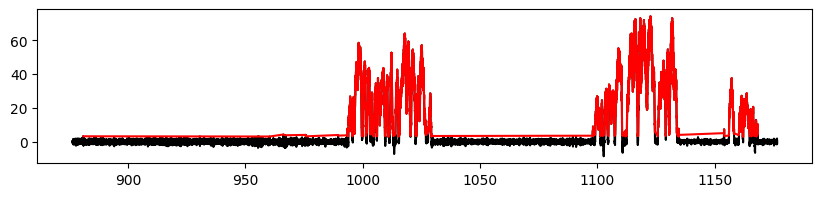

In [16]:
ts = running_spont.coords['time'].values

fig, ax = plt.subplots(figsize=(10,2))
plt.plot(ts,running_spont,'-k')


mask = np.where(running_mask_spont == 1)[0]
plt.plot(ts[mask],running_spont.sel(time=ts[mask]),'-r')

In [28]:
@ray.remote
def correlation_FC(X,transform='fisher'):
    
    N, T = X.shape
            
    #Loop over each pair and calculate the correlation between signals i and j
    correlation_mat  = np.zeros((N,N))*np.nan
    for i in range(N):
        for j in range(i,N):
            if i == j:
                continue
            indy = np.where((~np.isnan(X[i])) & (~np.isnan(X[j])))[0]
            cc = np.corrcoef(X[i,indy],X[j,indy])[0,1]
            
            correlation_mat[i,j] = cc
            correlation_mat[j,i] = cc
            
#     #Apply transformation   
#     if transform == 'fisher':
#         correlation_mat = np.arctanh(correlation_mat)
        
    return correlation_mat

##===== Calculate correlation & shuffle distribution ======##
def calculate_correlation(data_array, running_mask, subtract_mean = False, nShuffles = 100,shuffle = False):
    N, T = data_array.shape

    FC = np.zeros((2,N,N))
    if shuffle:
        FC_shf = np.zeros((2,nShuffles,N,N))

    for iR, rstr in enumerate(['Rest','Running']):
        indy = np.where(running_mask == iR)[0]

        if len(indy) == 0:
            continue

        X = data_array[:,indy]

        if subtract_mean:
            X = X - np.mean(X,axis=0).reshape(1,-1)
            
        FC[iR] = ray.get(correlation_FC.remote(X))

        if shuffle:
            X_orig = X.copy()

            #Calculate shuffles
            for iShf in trange(nShuffles):
                X_shf = np.apply_along_axis(np.random.permutation, 1, X_orig)
                FC_shf[iR,iShf] = ray.get(correlation_FC.remote(X_shf))

            # #Rank correlations to shuffle
            # pval_uncorrected = 1-2*np.abs(np.array([[st.percentileofscore(FC_shf[:,i,j],FC_shf[i,j],kind='strict') for j in range(N)] for i in range(N)])/100 - .5)
                
            # mask, pval_corrected = fdrcorrection(pval_uncorrected.ravel())
            # pval_corrected = pval_corrected.reshape((N,N))
            # pval_corrected[np.diag_indices(N)] = 0
    
    if shuffle:
        FC, FC_shf
    else:
        FC

In [17]:
ray.init()

data_array = dF_traces[:,33:-32]
running_mask = running_mask_dff[33:-32]
N, T = data_array.shape

FC_dff = calculate_correlation(data_array, running_mask)

ray.shutdown()

2023-02-28 14:24:05,288	INFO worker.py:1553 -- Started a local Ray instance.


In [27]:
FC_dff

In [21]:
data_array = dF_traces[:,33:-32]
running_mask = running_mask_dff[33:-32]
N, T = data_array.shape

indy = np.where(running_mask == 0)[0]
X = data_array[:,indy]
tmp = ray.get(correlation_FC.remote(X))


2023-02-28 15:04:53,604	INFO worker.py:1553 -- Started a local Ray instance.


NameError: name 'title_strs' is not defined

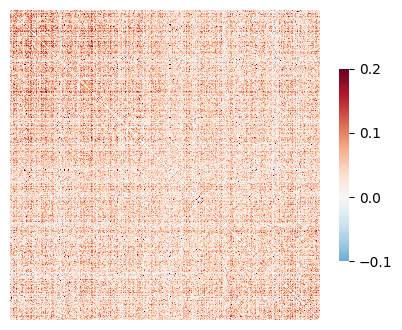

In [26]:
fig, ax = plt.subplots(figsize=(5,5))


sns.heatmap(tmp,ax=ax,cbar=True,square=True,cbar_kws={'shrink':0.5},vmin=-0.1,vmax=0.2,cmap='RdBu_r',center=0)
ax.axis('off')
ax.set_title(f'{title_strs[ii]}, {rstr}: {np.nanmean(FC[jj].ravel()):.3f}')

ax.vlines(boundaries,*ax.get_ylim(),color='k')
ax.hlines(boundaries,*ax.get_ylim(),color='k')

In [ ]:
ray.init()

data_array = event_traces[:,33:-32]
running_mask = running_mask_dff[33:-32]
N, T = data_array.shape

FC_events = calculate_correlation(data_array, running_mask)

ray.shutdown()

In [ ]:
ray.init()

data_array = spike_prob[:,33:-32]
running_mask = running_mask_dff[33:-32]
N, T = data_array.shape

FC_cascade = calculate_correlation(data_array, running_mask)

ray.shutdown()

In [76]:
data_array = dF_traces[:,33:-32]
running_mask = running_mask_dff[33:-32]
N, T = data_array.shape

FC_dff = np.zeros((2,N,N))

#Get rest epoch
indy = np.where(running_mask == 0)[0]
X = data_array[:,indy]

#Calculate correltion
FC_dff[0] = correlation_FC(X)

#Get running epoch
indy = np.where(running_mask == 1)[0]
X = data_array[:,indy]

FC_dff[1] = correlation_FC(X)

In [83]:
data_array = spike_prob[:,33:-32]
running_mask = running_mask_dff[33:-32]
N, T = data_array.shape

FC_cascade = np.zeros((2,N,N))

#Get rest epoch
indy = np.where(running_mask == 0)[0]
X = data_array[:,indy]

#Calculate correltion
FC_cascade[0] = correlation_FC(X)

#Get running epoch
indy = np.where(running_mask == 1)[0]
X = data_array[:,indy]

FC_cascade[1] = correlation_FC(X)

In [85]:
data_array = event_traces[:,33:-32]
running_mask = running_mask_dff[33:-32]
N, T = data_array.shape

FC_events = np.zeros((2,N,N))

#Get rest epoch
indy = np.where(running_mask == 0)[0]
X = data_array[:,indy]

#Calculate correltion
FC_events[0] = correlation_FC(X)

#Get running epoch
indy = np.where(running_mask == 1)[0]
X = data_array[:,indy]

FC_events[1] = correlation_FC(X)

In [110]:
DF_SAVE_DIR = r"/home/david.wyrick/Git/allen_v1dd/data_frames"

np.save(path.join(DF_SAVE_DIR,f'correlation_matrices_cascade_m{mouse_id}_{col}{vol}_20230221.npy'),FC_cascade)

<AxesSubplot: ylabel='Count'>

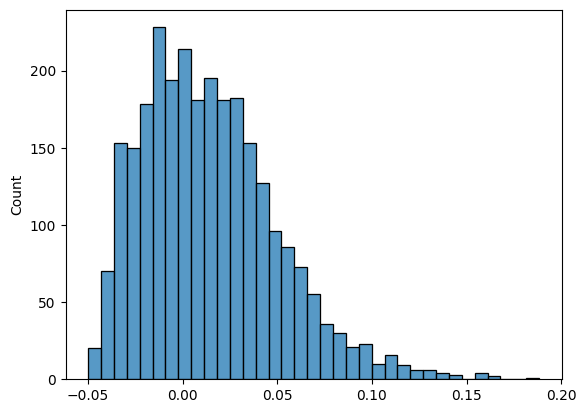

In [91]:
sns.histplot(FC_events[0,0])

In [25]:
boundaries =  np.concatenate(([0],np.cumsum(nNeurons_plane)))

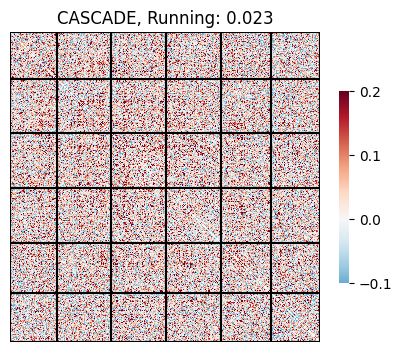

In [101]:
fig, ax = plt.subplots(figsize=(5,5))


sns.heatmap(FC[jj],ax=ax,cbar=True,square=True,cbar_kws={'shrink':0.5},vmin=-0.1,vmax=0.2,cmap='RdBu_r',center=0)
ax.axis('off')
ax.set_title(f'{title_strs[ii]}, {rstr}: {np.nanmean(FC[jj].ravel()):.3f}')

ax.vlines(boundaries,*ax.get_ylim(),color='k')
ax.hlines(boundaries,*ax.get_ylim(),color='k')

In [1]:
import h5py

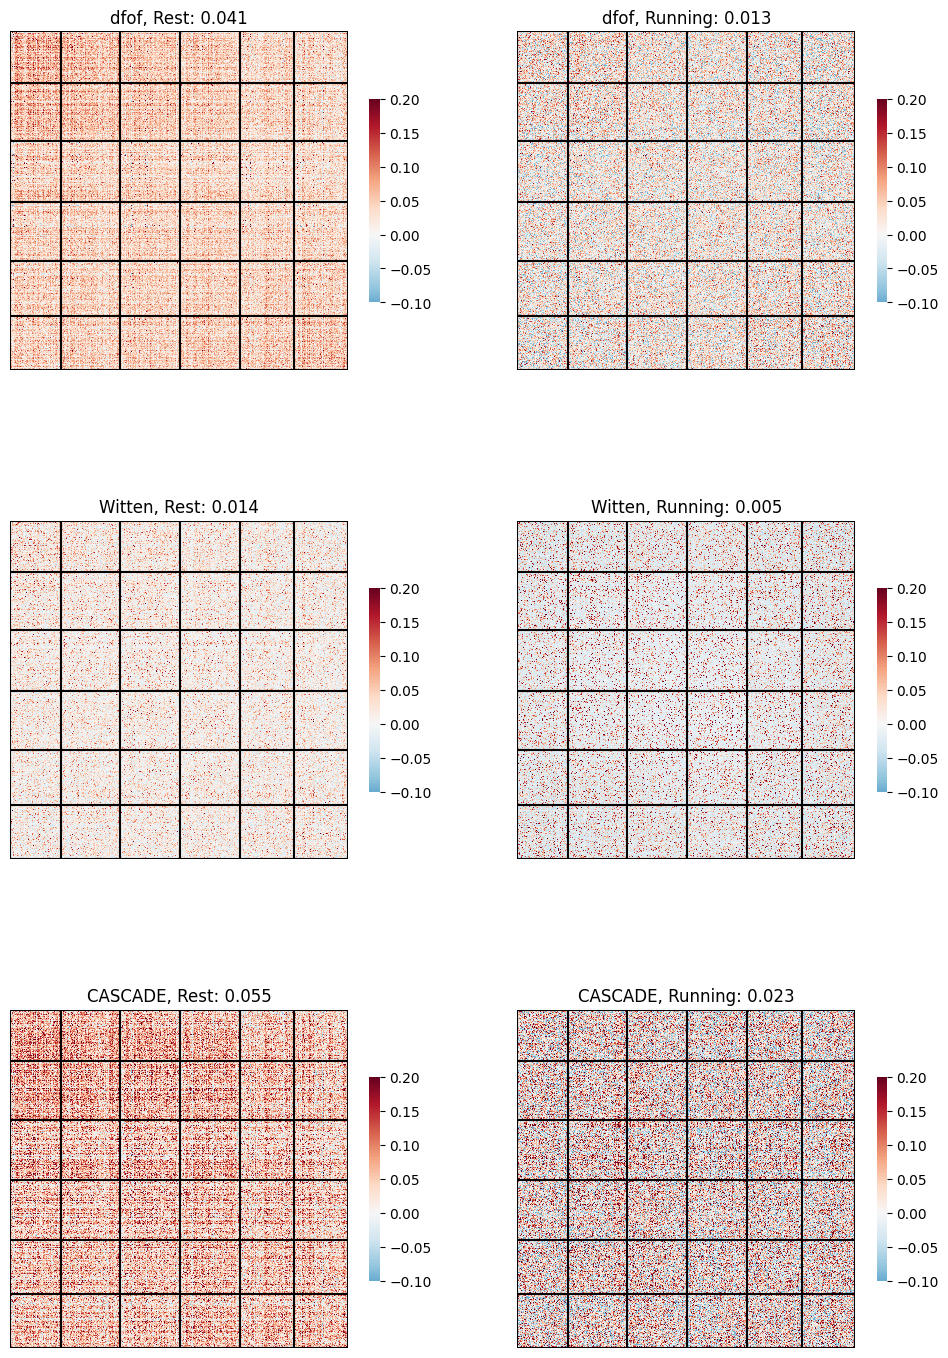

In [103]:
fig, axes = plt.subplots(3,2,figsize=(12,18))
title_strs = ['dfof','Witten','CASCADE']
for ii, FC in enumerate([FC_dff, FC_events, FC_cascade]):
    for jj, rstr in enumerate(['Rest','Running']):
        sns.heatmap(FC[jj],ax=axes[ii,jj],cbar=True,square=True,cbar_kws={'shrink':0.5},vmin=-0.1,vmax=0.2,cmap='RdBu_r',center=0)
        axes[ii,jj].axis('off')
        axes[ii,jj].set_title(f'{title_strs[ii]}, {rstr}: {np.nanmean(FC[jj].ravel()):.3f}')

        ax = axes[ii,jj]
        ax.vlines(boundaries,*ax.get_ylim(),color='k')
        ax.hlines(boundaries,*ax.get_ylim(),color='k')

        


    
    # sns.histplot(FC[iR].ravel(),ax=axes[iR],color=cc[iR])


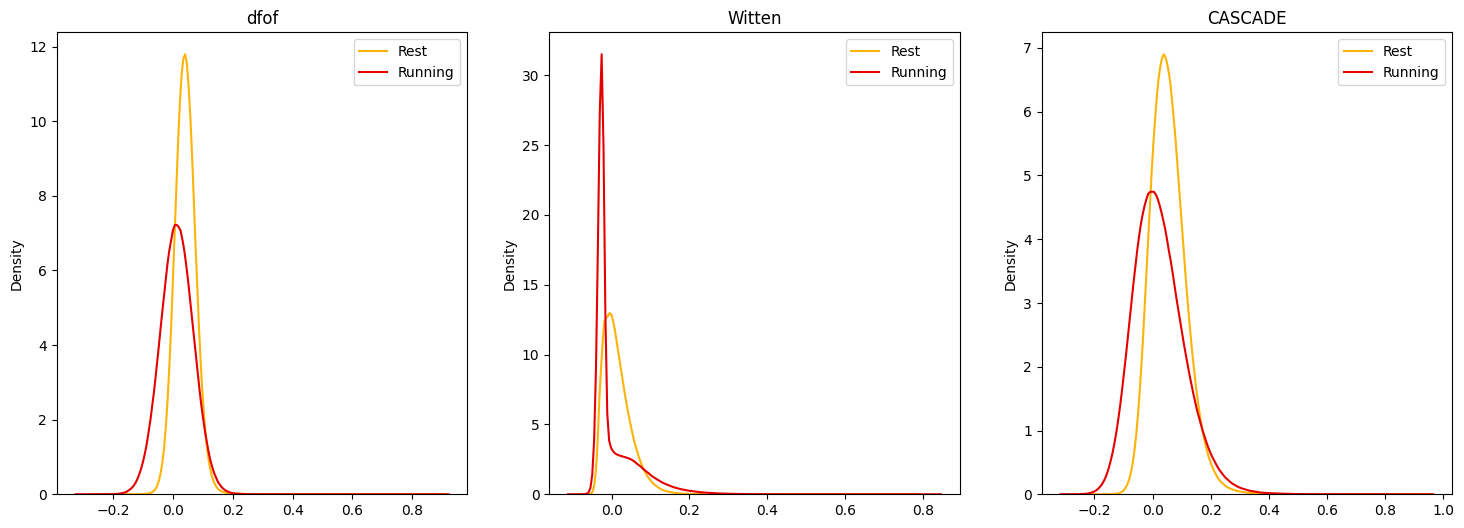

In [107]:
fig, axes = plt.subplots(1,3,figsize=(18,6))
title_strs = ['dfof','Witten','CASCADE']
for ii, FC in enumerate([FC_dff, FC_events, FC_cascade]):
    for jj, rstr in enumerate(['Rest','Running']):
        sns.kdeplot(FC[jj].ravel(),color=cc[jj],ax=axes[ii],label=rstr)
        axes[ii].set_title(f'{title_strs[ii]}')
        axes[ii].legend() 
    
    # sns.histplot(FC[iR].ravel(),ax=axes[iR],color=cc[iR])


## Networkx